In [1]:
! pip install -qq separability seaborn
from separability import Model
import matplotlib.pyplot as plt
import seaborn as sns
import torch

opt = Model("facebook/opt-125m", limit=1000)

- Loaded facebook/opt-125m
 - Registered 12 Attention Layers


tensor(4.9883, device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>)


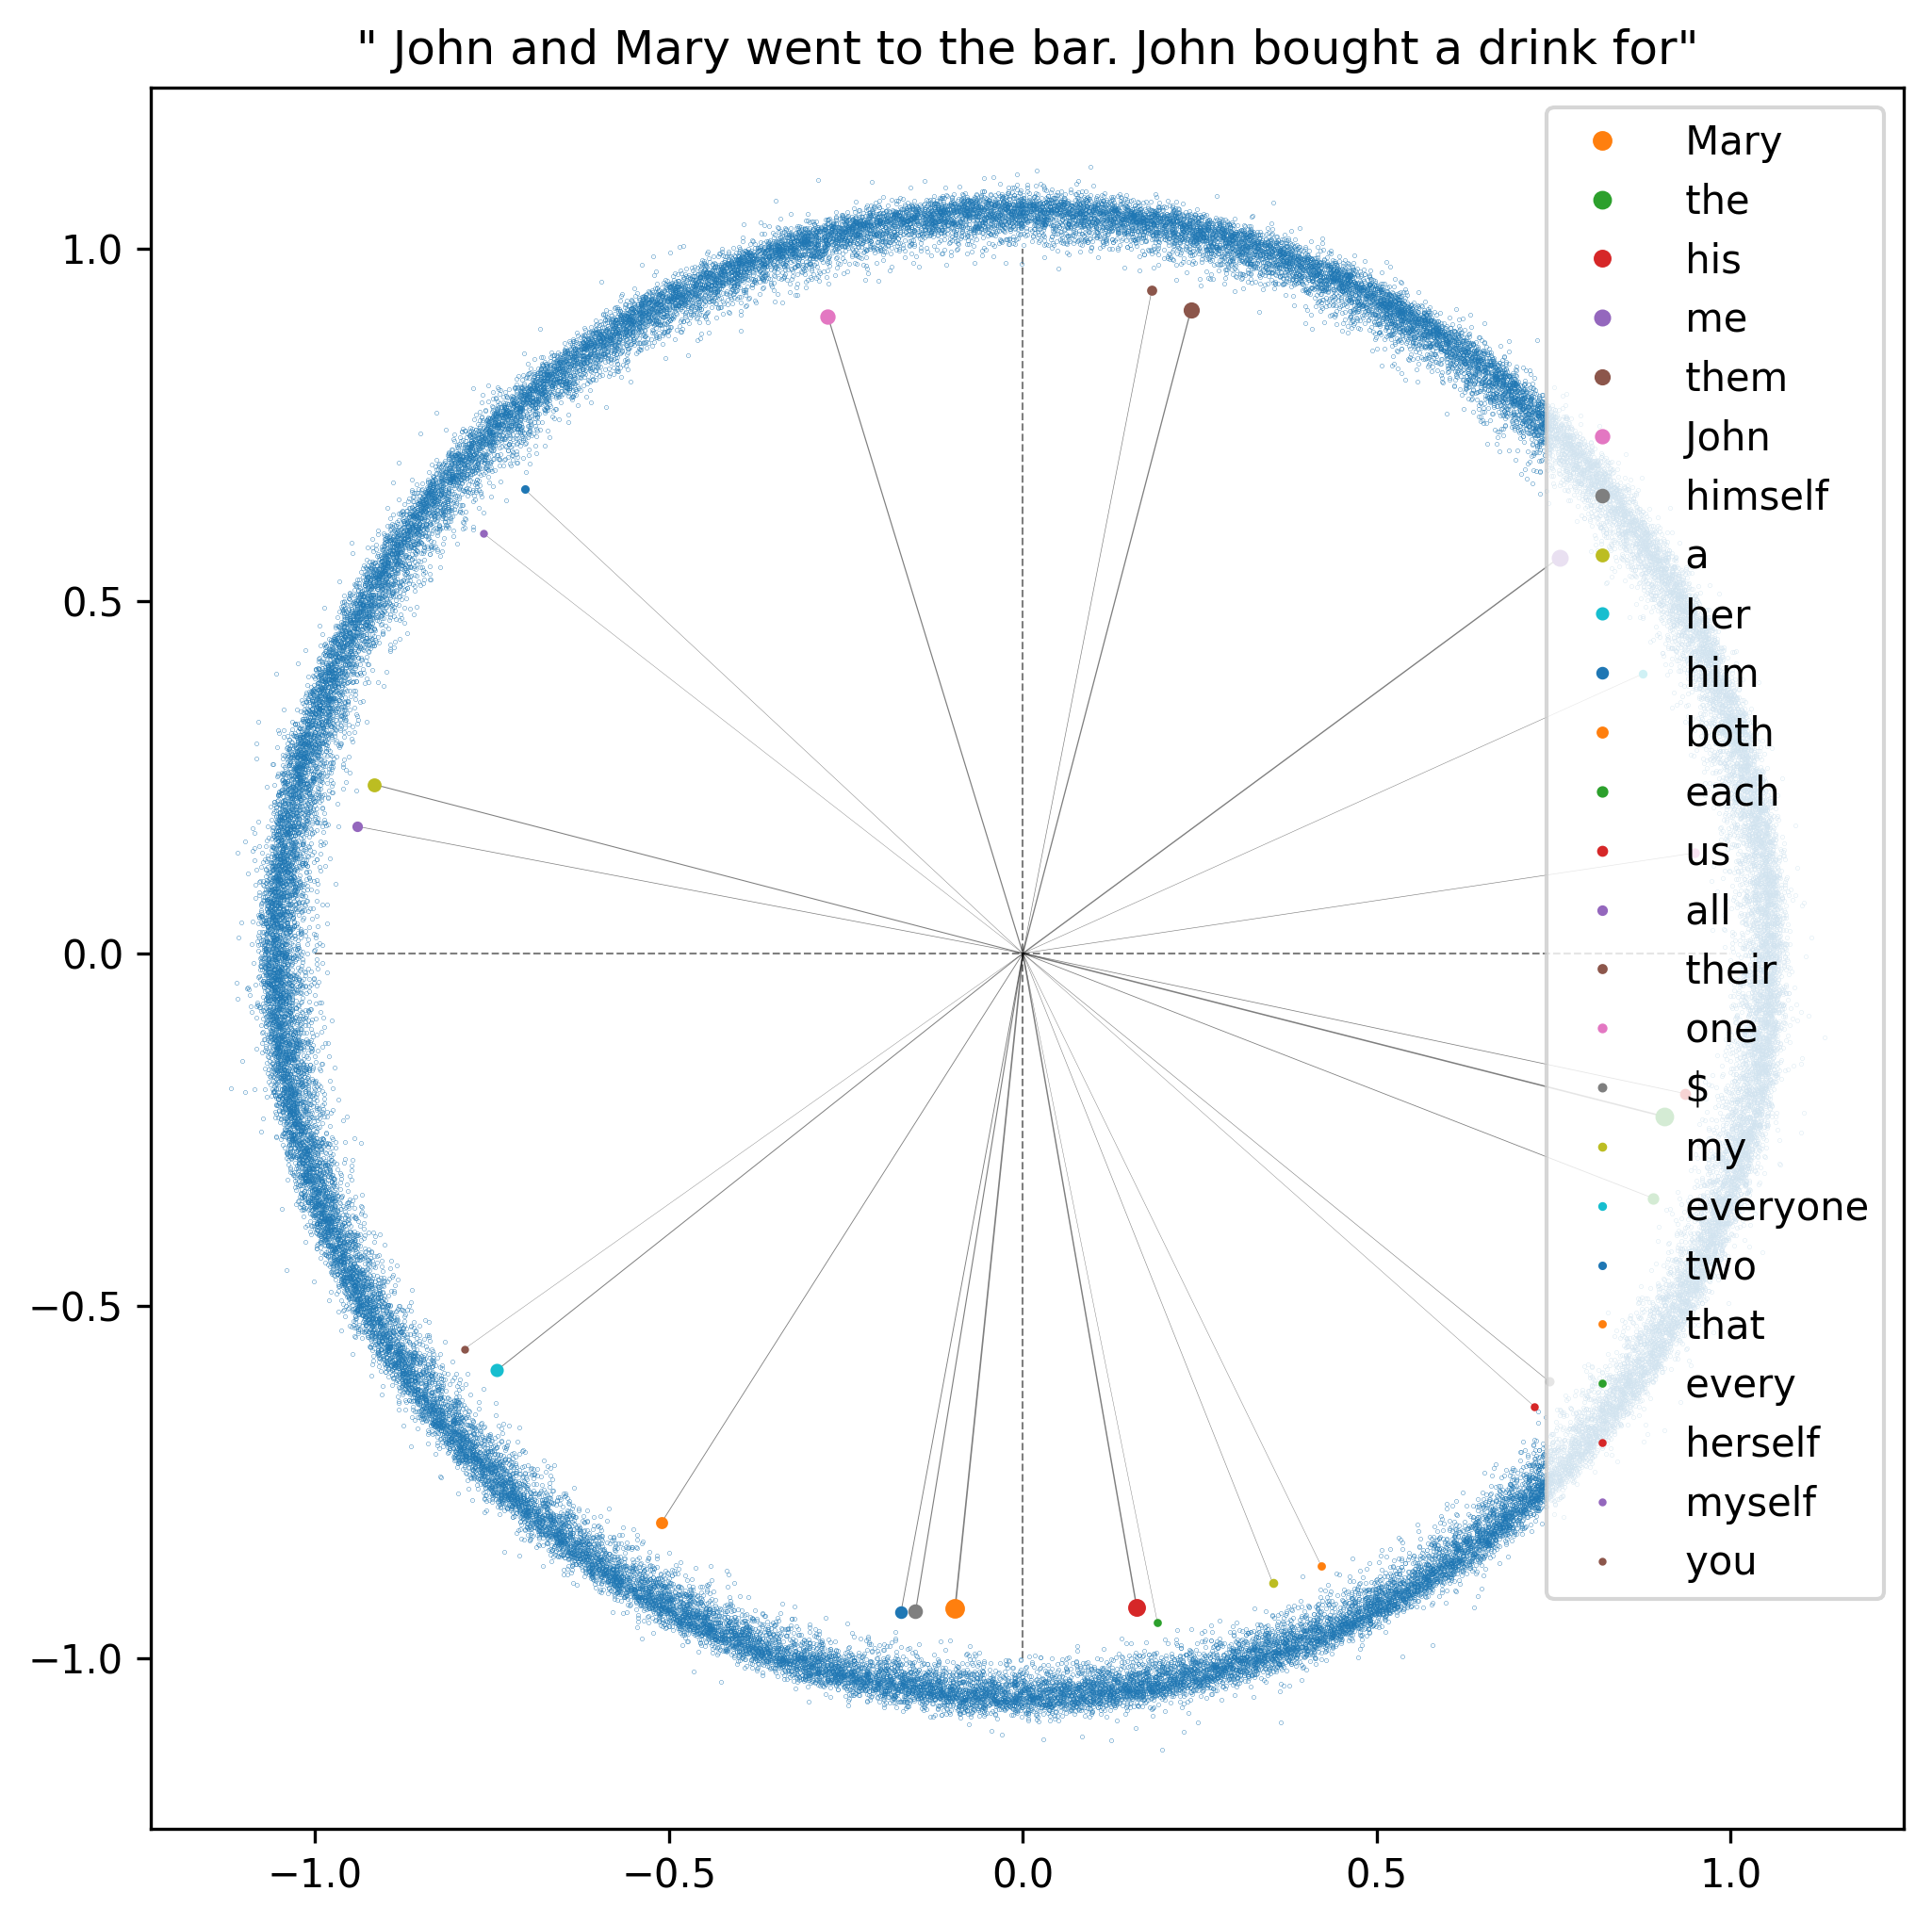

In [2]:
lm_head = opt.map["unembed.W_U"].T
# lm_head = lm_head / lm_head.norm(dim=1).unsqueeze(1)

text = " John and Mary went to the bar. John bought a drink for"
text_residual = opt.get_residual_stream(text)
token_residual = text_residual.transpose(0,1)[-1]

# Get the output vector
out_vec = token_residual[-1]
out_vec = opt.map["ln_final"](out_vec)

# normalize the output vector
out_vec = out_vec / out_vec.norm()

# get logits
logits = opt.unembed(out_vec.detach())
logits = torch.matmul(lm_head, out_vec)

# normalise logits by largest logit norm
logit_norm = lm_head.norm(dim=-1).max()
logits = logits / logit_norm
print(logit_norm)

# We need fudge_factor = logits.max() to make logits - fudge_factor negative
# However, logits - out_vec.norm() is what we need for an accurate graph
# To make a pretty graph, I do somewhere in between
# fudge_scaling: 0.0 is true life, 1.0 has closest token at origin
fudge_scaling = 0.5
fudge_factor = ( (1-fudge_scaling)*out_vec.norm() + fudge_scaling)
#fudge_factor = out_vec.norm()

# Make all logits negative
distance = (logits - fudge_factor).abs()

# Calculate random vectors that are scaled based on distance
with torch.no_grad():
    rand_vectors = torch.randn( len(distance), 2 ).detach()
    rand_vectors = rand_vectors / rand_vectors.norm(dim=1).unsqueeze(1)
    rand_vectors = rand_vectors * distance.unsqueeze(1).cpu()

# Create figure
plt.figure(figsize=(8,8))
plt.hlines(0, -1, 1, linestyles='dashed', colors='black', alpha=0.5, linewidth=0.5)
plt.vlines(0, -1, 1, linestyles='dashed', colors='black', alpha=0.5, linewidth=0.5)

# Plot all points
xs, ys = rand_vectors[:, 0], rand_vectors[:, 1]
plt.plot( xs, ys, "o", markersize=0.1 )

# Put visual emphasis on best predictions
n_top_predictions = 25
top_indices = torch.topk(-distance, n_top_predictions).indices
for token_rank, token_id in enumerate(top_indices):
    i_str = opt.tokenizer.decode(token_id)
    i_size = 1 + 3 * ( (n_top_predictions - token_rank)/ n_top_predictions )**2
    plt.plot( [0, xs[token_id]], [0, ys[token_id]], "k-", linewidth=i_size/10, alpha=0.5)
    plt.plot( xs[token_id], ys[token_id], "o", markersize=i_size, label=i_str )

plt.legend(loc="upper right")
plt.title('"'+text+'"')
plt.show()

In [30]:
with torch.no_grad():
    W_U = opt.map["unembed.W_U"].T
    W_U = W_U * (1 / W_U.norm(dim=-1)).unsqueeze(-1)
    W_U = W_U[:20000, :]

    self_logits = []
    for vec in W_U:
        self_logits.append(
            torch.nn.functional.linear(vec, W_U)
        )

    self_logits = torch.stack(self_logits)
    self_logits = torch.sort(self_logits, dim=-1, descending=True).values
    self_logits = torch.sort(self_logits, dim=0, descending=True).values

In [ ]:
plt.figure(figsize=(10,40))
sns.heatmap(self_logits.detach().cpu().numpy()[:, :2000], annot=False, center=0)

In [37]:
W_random = torch.randn(20000, 768).to('cuda').to(torch.float16)*2 - 1

In [38]:
with torch.no_grad():
    W_rand = W_random
    W_rand = W_rand * (1 / W_rand.norm(dim=-1)).unsqueeze(-1)
    W_rand = W_rand[:20000, :]

    rand_logits = []
    for vec in W_rand:
        rand_logits.append(
            torch.nn.functional.linear(vec, W_rand)
        )

    rand_logits = torch.stack(rand_logits)
    #rand_logits = torch.sort(rand_logits, dim=-1, descending=True).values
    #rand_logits = torch.sort(rand_logits, dim=0, descending=True).values

In [ ]:
plt.figure(figsize=(10,40))
sns.heatmap(rand_logits.detach().cpu().numpy()[:, :1000], annot=False, center=0)